## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №28

#### Оценить возраст человека по изображению. 

#### Часть 3. Вариант решения задачи как задачи регрессии

В качестве датасета взят датасет лиц по ссылке 
https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar

In [1]:
import math
import numpy as np
import pandas as pd

import cv2
import dlib
from PIL import Image
from imutils import face_utils
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical

from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score

RANDOM_STATE = 42

print('Cuda version: ' + tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('OpenCV version ' + cv2.__version__)

Cuda version: 2.10.1
Num GPUs Available:  1
OpenCV version 4.7.0


Загружаем описание набора данных

In [2]:
df = pd.read_csv('imdb_crops.csv')
df.head(5)

,Unnamed: 0,file_path,label
0,0,wiki_crop\cropped\10049200_1891-09-16_1958.jpg,67
1,1,wiki_crop\cropped\10110600_1985-09-17_2012.jpg,27
2,2,wiki_crop\cropped\1013900_1917-10-15_1960.jpg,43
3,3,wiki_crop\cropped\10166400_1960-03-12_2008.jpg,48
4,4,wiki_crop\cropped\10292500_1984-03-26_2009.jpg,25


1. Сформируем из изображений набор данных, как набор массивов евклидовых расстояний между точками признаков лица

In [4]:
face_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

X = []
labels = []

# Расчет евкидова расстояния между двумя точками
def calc_euclidean(a, b):
    return math.sqrt(math.pow((b[0] - a[0]), 2) + math.pow((b[1] - a[1]), 2))

# Расчет евкидовых расстояний между всеми заданными точками
def calc_euclidean_all(l):
    distances = np.zeros((68,68))
    for i in range(0, len(l)):
        for j in range(0, len(l)):
            distances[i][j] = calc_euclidean(l[i], l[j])
    return distances

# Загрузка изображений и формирования набора признаков
for index, row in tqdm(df.iterrows()):
    
    img = np.array(Image.open(row.file_path))

    w, h = img.shape[:2]
    landmarks = face_predictor(img, dlib.rectangle(0,0,w,h))

    # Сформировать признаки изображения как массив 68x68 евклидовых расстояние между всеми метками (landmarks) изображения 
    distances = calc_euclidean_all(face_utils.shape_to_np(landmarks))
    X.append(distances)

    labels.append(row.label)

X = np.asarray(X)
labels = np.asarray(labels)

print(f'Загружен массив изображений\n {X.shape}')

32787it [04:40, 116.86it/s]


Загружен массив изображений
 (32787, 68, 68)


Подготовим обучающий и тестовые наборы данных

In [5]:
y = labels

# Перемешаем случайным образом исходные массивы изображений и меток
indices = np.arange(X.shape[0])

np.random.seed(RANDOM_STATE)
np.random.shuffle(indices)
X, y = X[indices], y[indices]

# Выполним разбиение масивов на обучающий и тестовый наборы
train_length = int(X.shape[0] * 0.7)
X_train, X_test = X[:train_length], X[train_length:]
y_train, y_test = y[:train_length], y[train_length:]

Построим и выполним обучение плотной нейронной сети

In [39]:
keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)

model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[68, 68]),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(4096, kernel_initializer='he_normal', activation='ReLU'),
    #keras.layers.BatchNormalization(),
    #keras.layers.Activation('ReLU'),
    #keras.layers.Dropout(0.2),
    
    keras.layers.Dense(1, activation='linear')
])

model1.compile(loss='mse', 
              optimizer=keras.optimizers.Nadam(learning_rate=0.01), 
              metrics=['mae'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_mae',
        min_delta=1e-4,
        patience=10,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        #monitor='val_categorical_accuracy',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'keras_imdb_reg_model1.h5',
        monitor = 'val_mae',
        save_Best_only=True
    )
]

print('Model summary:')
print(model1.summary())

Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4624)              0         
                                                                 
 batch_normalization (BatchN  (None, 4624)             18496     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 4096)              18944000  
                                                                 
 dense_1 (Dense)             (None, 1)                 4097      
                                                                 
Total params: 18,966,593
Trainable params: 18,957,345
Non-trainable params: 9,248
_________________________________________________________________
None


In [40]:
#with tf.device('/cpu:0'):
with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train, batch_size=512, epochs=100,
                        callbacks=callbacks, 
                        validation_split=0.2, 
                        #class_weight = class_weights,
                        verbose=1)

print('\nModel history:')
print(history1.history.keys())

Epoch 1/100
36/36 [==============================] - 3s 57ms/step - loss: 21340.7090 - mae: 62.9029 - val_loss: 4137670.7500 - val_mae: 2023.6747 - lr: 0.0100
Epoch 2/100
36/36 [==============================] - 2s 51ms/step - loss: 909.9774 - mae: 19.6830 - val_loss: 16843.9785 - val_mae: 125.8963 - lr: 0.0100
Epoch 3/100
36/36 [==============================] - 2s 50ms/step - loss: 305.6453 - mae: 13.5371 - val_loss: 9171.3711 - val_mae: 90.9247 - lr: 0.0100
Epoch 4/100
36/36 [==============================] - 2s 51ms/step - loss: 368.6904 - mae: 15.0264 - val_loss: 273.1875 - val_mae: 12.4157 - lr: 0.0100
Epoch 5/100
36/36 [==============================] - 2s 50ms/step - loss: 238.1385 - mae: 11.9244 - val_loss: 310.3015 - val_mae: 14.3109 - lr: 0.0100
Epoch 6/100
36/36 [==============================] - 2s 52ms/step - loss: 309.0027 - mae: 13.5384 - val_loss: 329.1701 - val_mae: 14.9596 - lr: 0.0100
Epoch 7/100
36/36 [==============================] - 2s 49ms/step - loss: 204.5784

In [41]:
scores1 = model1.evaluate(X_test, y_test, verbose=0)

print("МАЕ на тестовых данных: %.2f%%" % (scores1[1]))

МАЕ на тестовых данных: 9.68%


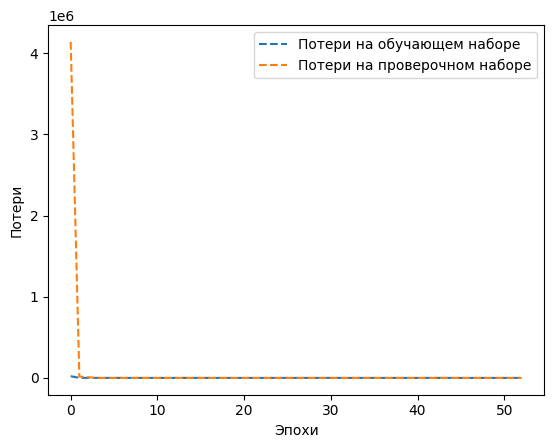

In [42]:
plt.plot(history1.history['loss'], linestyle = '--', label='Потери на обучающем наборе')
plt.plot(history1.history['val_loss'], linestyle = '--', label='Потери на проверочном наборе')
plt.ylabel('Потери')
plt.xlabel('Эпохи')
plt.legend()
plt.show()

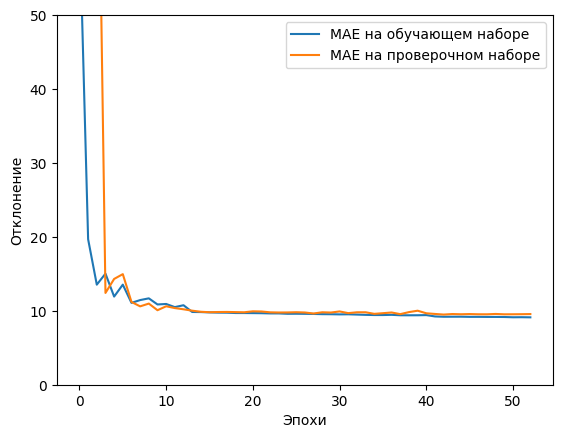

In [43]:
plt.plot(history1.history['mae'], label='MAE на обучающем наборе')
plt.plot(history1.history['val_mae'], label='MAE на проверочном наборе')
plt.ylim([0,50])
plt.ylabel('Отклонение')
plt.xlabel('Эпохи')
plt.legend()
plt.show()

Вариант 2. Сформируем из изображений набор данных, как набор массивов монохромных изображений, приведенных к единому разрешению

In [99]:
X = []
labels = []

# Загрузка изображений и формирования набора признаков
for index, row in tqdm(df.iterrows()):
    
    img = np.asarray(Image.open(row.file_path).resize((64,64)))

    #blob = cv2.dnn.blobFromImage(img, scalefactor=1/255, size=(128, 128))
    #X.append(np.asarray(blob[0][0]))
    X.append(np.asarray(img))

    labels.append(row.label)

X = np.asarray(X)
labels = np.asarray(labels)

print(f'Загружен массив изображений\n {X.shape}')

32787it [00:14, 2317.97it/s]


Загружен массив изображений
 (32787, 64, 64)


In [100]:
y = labels

# Перемешаем случайным образом исходные массивы изображений и меток
indices = np.arange(X.shape[0])

np.random.seed(RANDOM_STATE)
np.random.shuffle(indices)
X, y = X[indices], y[indices]

# Выполним разбиение масивов на обучающий и тестовый наборы
train_length = int(X.shape[0] * 0.7)
X_train, X_test = X[:train_length], X[train_length:]
y_train, y_test = y[:train_length], y[train_length:]

Проверим один из элементов получившихся наборов данных

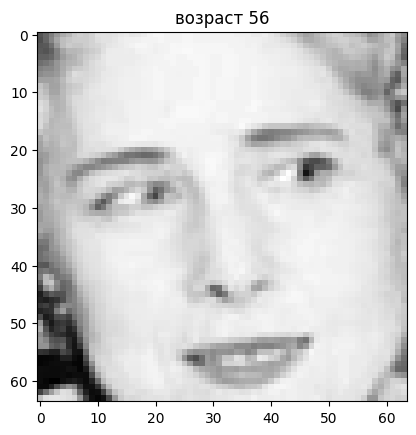

In [101]:
plt.imshow(X_train[0], cmap='gray')
plt.title(f'возраст {y_train[0]}');

Построим модель на базе плотной нейронной сети

In [114]:
keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)

model2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[64, 64]),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(4096, kernel_initializer='he_normal', activation='ReLU'),
    keras.layers.BatchNormalization(),
    #keras.layers.Activation('ReLU'),
    #keras.layers.Dropout(0.2),
    
    keras.layers.Dense(1, activation='linear')
])

model2.compile(loss='mse', 
              optimizer=keras.optimizers.Nadam(learning_rate=0.01), 
              metrics=['mae'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_mae',
        min_delta=1e-4,
        patience=10,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        #monitor='val_mae',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'keras_imdb_reg_model2.h5',
        monitor = 'val_mae',
        save_Best_only=True
    )
]

print('Model summary:')
print(model2.summary())

Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 4096)              16781312  
                                                                 
 batch_normalization_1 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 4097      
                                                                 
Total params: 16,818,177
Trainable params

In [115]:
with tf.device('/gpu:0'):
    history2 = model2.fit(X_train, y_train, batch_size=512, epochs=100,
                        callbacks=callbacks, 
                        validation_split=0.2, 
                        #class_weight = class_weights,
                        verbose=1)
    
print('\nModel history:')
print(history2.history.keys())

Epoch 1/100
36/36 [==============================] - 3s 52ms/step - loss: 932.5691 - mae: 24.2538 - val_loss: 10793.4209 - val_mae: 94.4986 - lr: 0.0100
Epoch 2/100
36/36 [==============================] - 2s 47ms/step - loss: 256.5273 - mae: 12.5641 - val_loss: 322.5968 - val_mae: 13.8850 - lr: 0.0100
Epoch 3/100
36/36 [==============================] - 2s 48ms/step - loss: 244.8908 - mae: 12.3113 - val_loss: 629.0463 - val_mae: 20.3042 - lr: 0.0100
Epoch 4/100
36/36 [==============================] - 2s 47ms/step - loss: 239.5604 - mae: 12.1685 - val_loss: 559.4818 - val_mae: 18.8338 - lr: 0.0100
Epoch 5/100
36/36 [==============================] - 2s 47ms/step - loss: 208.4244 - mae: 11.3657 - val_loss: 219.9191 - val_mae: 11.4255 - lr: 0.0100
Epoch 6/100
36/36 [==============================] - 2s 48ms/step - loss: 211.7671 - mae: 11.3745 - val_loss: 595.0159 - val_mae: 19.2845 - lr: 0.0100
Epoch 7/100
36/36 [==============================] - 2s 48ms/step - loss: 219.7895 - mae: 11

In [116]:
scores2 = model2.evaluate(X_test, y_test, verbose=0)

print("Точность на тестовых данных: %.2f%%" % (scores2[1]))

Точность на тестовых данных: 8.63%


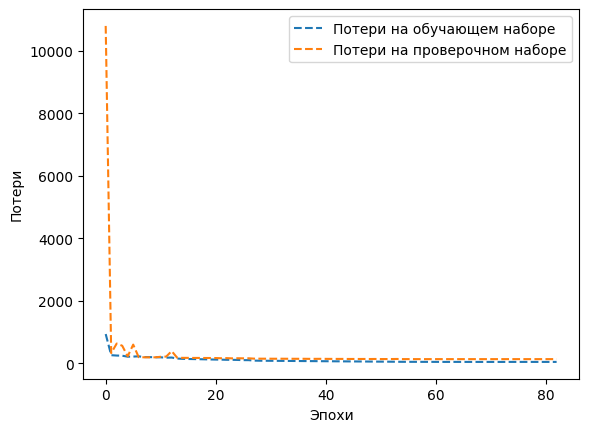

In [117]:
plt.plot(history2.history['loss'], linestyle = '--', label='Потери на обучающем наборе')
plt.plot(history2.history['val_loss'], linestyle = '--', label='Потери на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

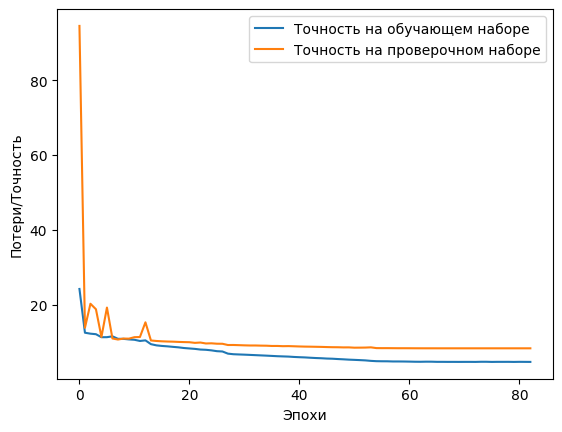

In [118]:
plt.plot(history2.history['mae'], label='Точность на обучающем наборе')
plt.plot(history2.history['val_mae'], label='Точность на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери/Точность')
plt.legend()
plt.show()

Построим модель на базе сверточной нейронной сети

In [125]:
tf.keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)

K = 32
N = 1024

model3 = keras.models.Sequential([
    keras.layers.Conv2D(K, (3,3), padding='SAME', kernel_initializer='he_normal', activation='ReLU', input_shape=(64, 64, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
  
    keras.layers.Conv2D(K*2, (3,3), padding='SAME', kernel_initializer='he_normal', activation='ReLU'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Conv2D(K*4, (3,3), padding='SAME', kernel_initializer='he_normal', activation='ReLU'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Flatten(),

    keras.layers.Dense(N, kernel_initializer='he_normal', activation='ReLU'),
    #keras.layers.Dropout(0.5),

    keras.layers.Dense(1, activation='linear')
])

model3.compile(loss='mse', 
              optimizer=keras.optimizers.Nadam(learning_rate=0.005), 
              metrics=['mae'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_mae',
        min_delta=1e-4,
        patience=10,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        #monitor='val_mae',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'keras_imdb_reg_model3.h5',
        monitor = 'val_mae',
        save_Best_only=True
    )
]

print('Model summary:')
print(model3.summary())

Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                         

In [126]:
with tf.device('/gpu:0'):
    history3 = model3.fit(X_train, y_train, batch_size=512, epochs=100,
                        callbacks=callbacks, 
                        validation_split=0.2, 
                        #class_weight = class_weights,
                        verbose=1)
    
print('\nModel history:')
print(history3.history.keys())

Epoch 1/100
36/36 [==============================] - 5s 94ms/step - loss: 10113.1260 - mae: 31.3874 - val_loss: 1955.0255 - val_mae: 39.1846 - lr: 0.0050
Epoch 2/100
36/36 [==============================] - 3s 88ms/step - loss: 233.3026 - mae: 12.0579 - val_loss: 328.9025 - val_mae: 14.9637 - lr: 0.0050
Epoch 3/100
36/36 [==============================] - 3s 88ms/step - loss: 211.4814 - mae: 11.4484 - val_loss: 321.6577 - val_mae: 13.3113 - lr: 0.0050
Epoch 4/100
36/36 [==============================] - 3s 88ms/step - loss: 191.7778 - mae: 10.8278 - val_loss: 285.4409 - val_mae: 12.5136 - lr: 0.0050
Epoch 5/100
36/36 [==============================] - 3s 88ms/step - loss: 180.9825 - mae: 10.4955 - val_loss: 188.8244 - val_mae: 10.6167 - lr: 0.0050
Epoch 6/100
36/36 [==============================] - 3s 88ms/step - loss: 166.5522 - mae: 10.0634 - val_loss: 195.5982 - val_mae: 10.5368 - lr: 0.0050
Epoch 7/100
36/36 [==============================] - 3s 88ms/step - loss: 160.8140 - mae: 9

In [127]:
scores3 = model3.evaluate(X_test, y_test, verbose=0)

print("Точность на тестовых данных: %.2f%%" % (scores3[1]))

Точность на тестовых данных: 6.63%


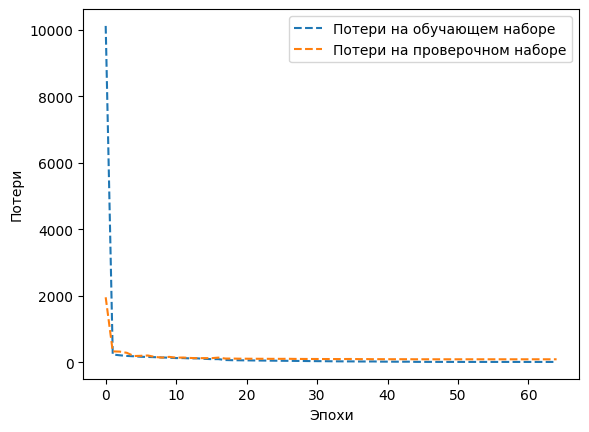

In [128]:
plt.plot(history3.history['loss'], linestyle = '--', label='Потери на обучающем наборе')
plt.plot(history3.history['val_loss'], linestyle = '--', label='Потери на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

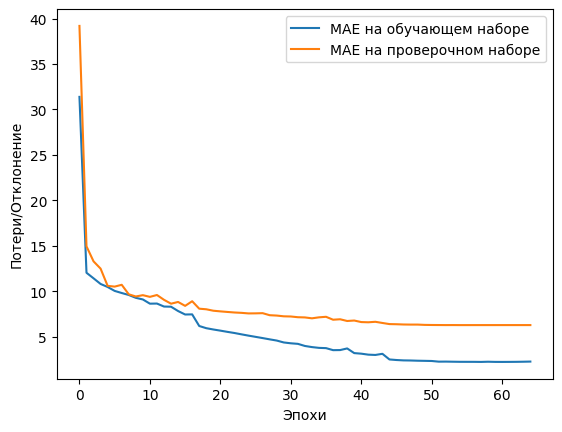

In [129]:
plt.plot(history3.history['mae'], label='MAE на обучающем наборе')
plt.plot(history3.history['val_mae'], label='MAE на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери/Отклонение')
plt.legend()
plt.show()

Сравним метрики всех обученных моделей

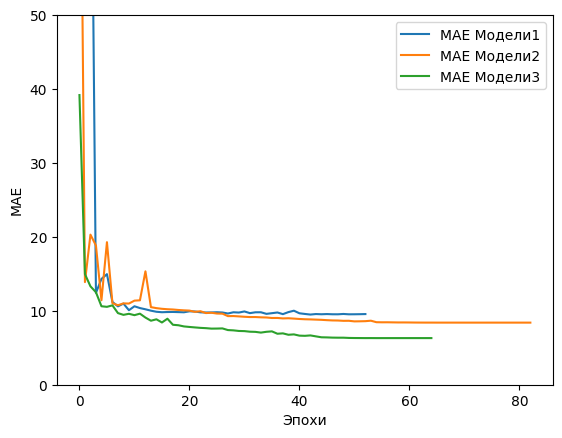

In [131]:
plt.plot(history1.history['val_mae'], label='MAE Модели1')
plt.plot(history2.history['val_mae'], label='MAE Модели2')
plt.plot(history3.history['val_mae'], label='MAE Модели3')
plt.ylim([0,50])
plt.xlabel('Эпохи')
plt.ylabel('MAE')
plt.legend()
plt.show()